
# Tech Challenge – Fase 3  
## Análise do Impacto Clínico e do Estilo de Vida na COVID-19 no Brasil  
**Autor:** Vitor Santos  
**RM:** rm366038

Este notebook analisa microdados da PNAD-COVID (IBGE) para compreender:

- Impacto clínico da COVID-19 (sintomas leves vs graves)
- Pressão sobre o sistema de saúde
- Testagem e positividade
- Influência do comportamento de proteção
- **Influência do estilo de vida (trabalho), região e estado**


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,6)


## 1. Carga dos dados (3 meses)

In [2]:

# Ajuste os caminhos conforme os arquivos no seu Colab
df05 = pd.read_csv('/content/PNAD_COVID_052020.csv')
df06 = pd.read_csv('/content/PNAD_COVID_062020.csv')
df07 = pd.read_csv('/content/PNAD_COVID_072020.csv')

df = pd.concat([df05, df06, df07], ignore_index=True)

print("Dimensão:", df.shape)
df.head()


Dimensão: (1114742, 145)


,Ano,UF,CAPITAL,RM_RIDE,V1008,V1012,V1013,V1016,Estrato,UPA,...,E001,E0021,E0022,E0023,E0024,F002A1,F002A2,F002A3,F002A4,F002A5
0,2020,11,11.0,NaN,1,4,5,1,1110011,110015970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,11,11.0,NaN,1,4,5,1,1110011,110015970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,11,11.0,NaN,1,4,5,1,1110011,110015970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,11,11.0,NaN,1,4,5,1,1110011,110015970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,11,11.0,NaN,3,2,5,1,1110011,110015970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Seleção de colunas relevantes

In [3]:

# Colunas clínicas, demográficas e de estilo de vida
colunas = [
    'A002',      # Idade
    'UF',        # Estado
    'V1013',     # Região
    'C007C',     # Condição de trabalho
    'B0011','B0012','B00111', # sintomas leves
    'B0014','B0015',          # sintomas graves
    'B002',      # procurou atendimento
    'B011',      # resultado do teste
    'F002A2',    # usa álcool
    'F002A3'     # usa máscara
]

df = df[colunas].copy()
df.head()


,A002,UF,V1013,C007C,B0011,B0012,B00111,B0014,B0015,B002,B011,F002A2,F002A3
0,35,11,5,35.0,1,1,1,2,1,2.0,NaN,NaN,NaN
1,29,11,5,34.0,1,1,1,2,2,2.0,NaN,NaN,NaN
2,13,11,5,NaN,2,2,2,2,2,NaN,NaN,NaN,NaN
3,10,11,5,NaN,2,2,2,2,2,NaN,NaN,NaN,NaN
4,58,11,5,NaN,2,2,2,2,2,NaN,NaN,NaN,NaN


## 3. Criação da faixa etária

In [4]:

def faixa(idade):
    if idade <= 17: return '0-17'
    if idade <= 39: return '18-39'
    if idade <= 59: return '40-59'
    return '60+'

df['faixa_etaria'] = df['A002'].apply(faixa)


## 4. Variáveis de proteção

In [5]:

df['usa_alcool'] = (df['F002A2'] == 1).astype(int)
df['usa_mascara'] = (df['F002A3'] == 1).astype(int)
df['nivel_protecao'] = df['usa_alcool'] + df['usa_mascara']


## 5. Variáveis de estilo de vida (trabalho)

In [6]:

# Considerando: trabalha = 1, não trabalha = 0 (ajuste se necessário conforme dicionário)
df['trabalha'] = (df['C007C'] == 1).astype(int)
df['trabalha'].value_counts()


,count
trabalha,
0,1091966
1,22776


## 6. Construção de indicadores clínicos

In [7]:

sintomas_leves = ['B0011','B0012','B00111']
sintomas_graves = ['B0014','B0015']

df[sintomas_leves] = (df[sintomas_leves] == 1).astype(int)
df[sintomas_graves] = (df[sintomas_graves] == 1).astype(int)

df['qtd_leves'] = df[sintomas_leves].sum(axis=1)
df['qtd_graves'] = df[sintomas_graves].sum(axis=1)

df['tem_grave'] = (df['qtd_graves'] > 0).astype(int)
df['caso_clinico_relevante'] = ((df['tem_grave']==1) | (df['qtd_leves']>=2)).astype(int)


## 7. Atendimento e testagem

In [8]:

df['procurou_atendimento'] = (df['B002'] == 1).astype(int)
df['teste_positivo'] = (df['B011'] == 1).astype(int)
df['fez_teste'] = (df['B011'].notna()).astype(int)


In [9]:

def plot_bar(series, title, ylabel='% da população'):
    ax = series.plot(kind='bar')
    plt.title(title)
    plt.ylabel(ylabel)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom')
    plt.tight_layout()
    plt.show()


## 8. Análise clínica principal

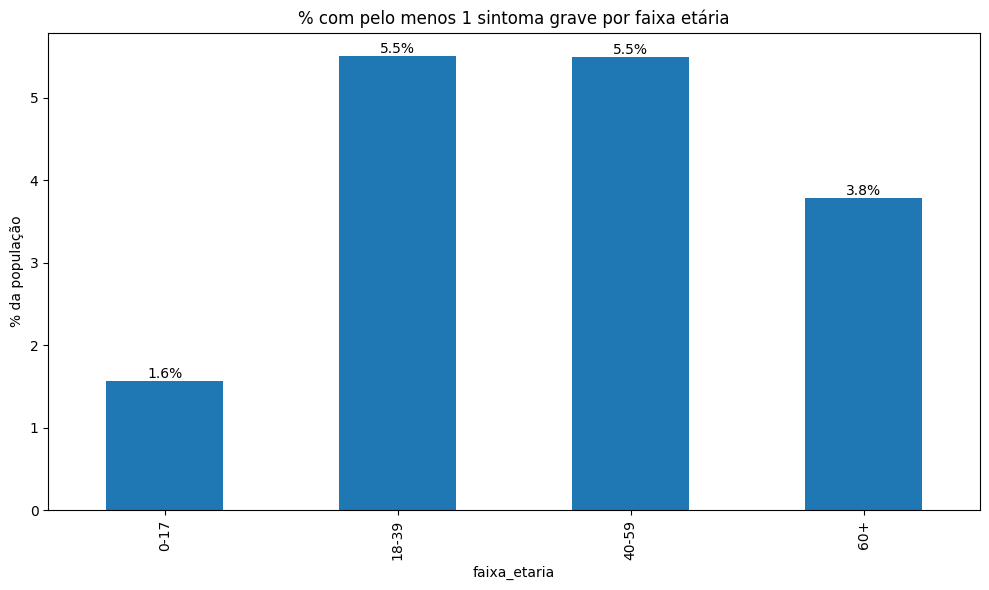

In [10]:

g1 = df.groupby('faixa_etaria')['tem_grave'].mean()*100
plot_bar(g1, '% com pelo menos 1 sintoma grave por faixa etária')


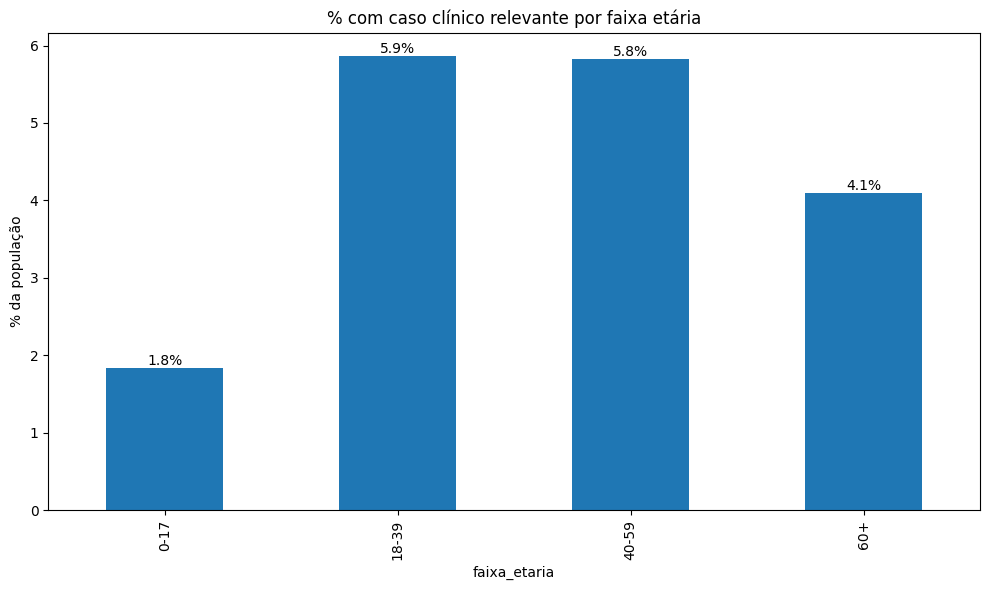

In [11]:

g2 = df.groupby('faixa_etaria')['caso_clinico_relevante'].mean()*100
plot_bar(g2, '% com caso clínico relevante por faixa etária')


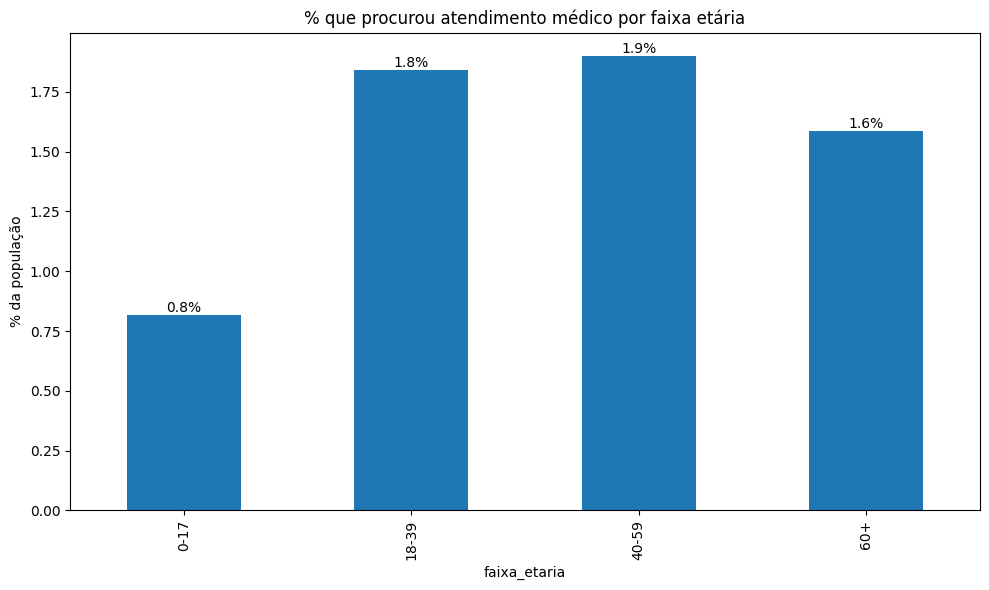

In [12]:

g3 = df.groupby('faixa_etaria')['procurou_atendimento'].mean()*100
plot_bar(g3, '% que procurou atendimento médico por faixa etária')


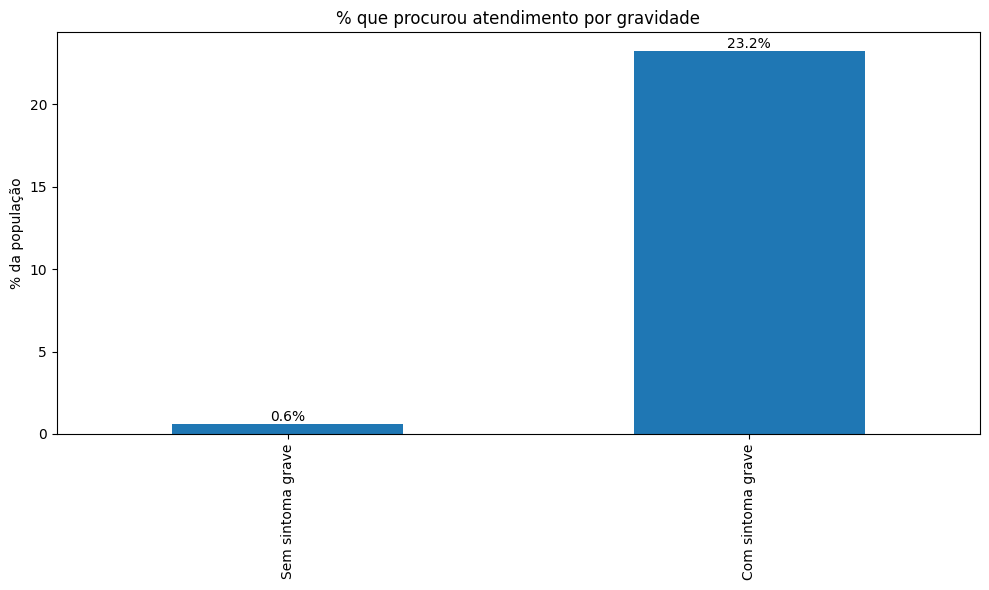

In [13]:

g4 = df.groupby('tem_grave')['procurou_atendimento'].mean()*100
g4.index = ['Sem sintoma grave','Com sintoma grave']
plot_bar(g4, '% que procurou atendimento por gravidade')


## 9. Impacto do estilo de vida (trabalho)

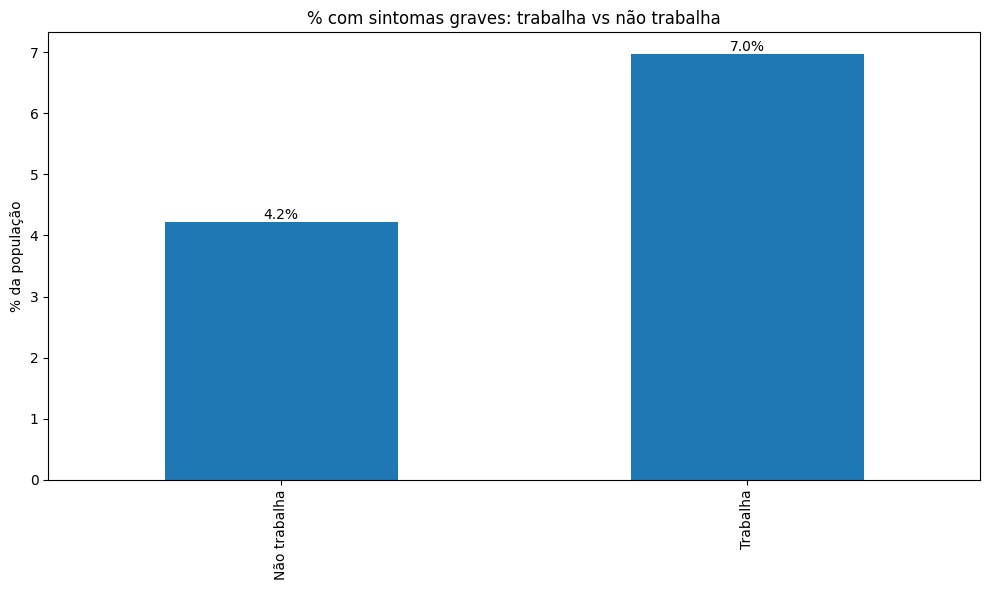

In [14]:

g_trab1 = df.groupby('trabalha')['tem_grave'].mean()*100
g_trab1.index = ['Não trabalha','Trabalha']
plot_bar(g_trab1, '% com sintomas graves: trabalha vs não trabalha')


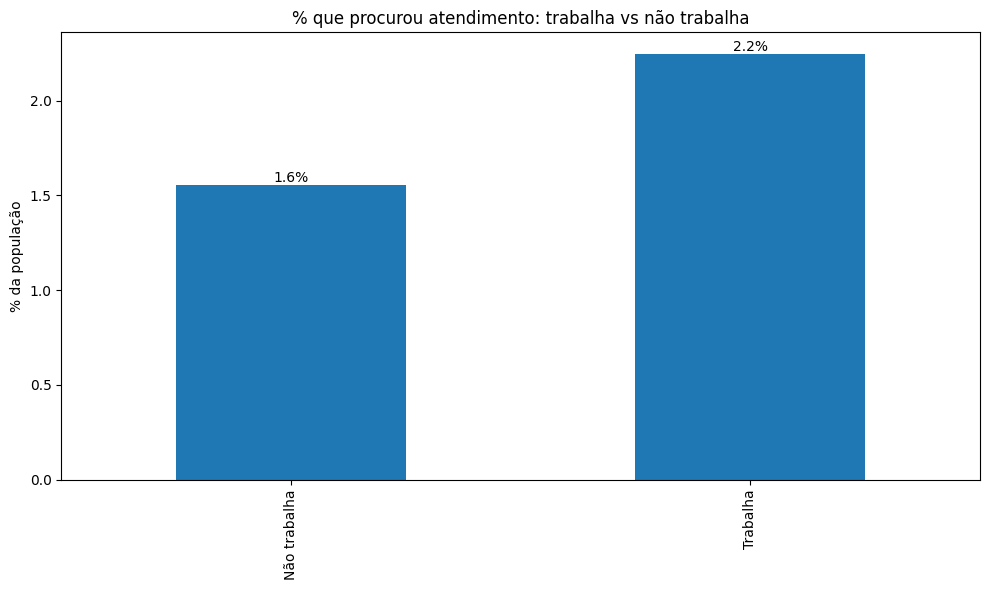

In [15]:

g_trab2 = df.groupby('trabalha')['procurou_atendimento'].mean()*100
g_trab2.index = ['Não trabalha','Trabalha']
plot_bar(g_trab2, '% que procurou atendimento: trabalha vs não trabalha')


## 10. Análise por região

## 11. Análise por estado (UF)

In [18]:

g_uf1 = df.groupby('UF')['tem_grave'].mean()*100
g_uf1.sort_values(ascending=False).head(10)


,tem_grave
UF,
16,10.042880
12,7.030152
14,6.968425
13,6.949062
15,6.529261
25,5.743003
21,5.250541
11,5.204437
23,5.035117


In [21]:

for col in ['B0014', 'B00110', 'B002', 'C007C', 'A002']:
    if col not in df.columns:
        df[col] = np.nan

# Converter para numérico
for col in ['B0014', 'B00110', 'B002', 'C007C', 'A002']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Variáveis clínicas
df['tem_grave'] = ((df['B0014'] == 1) | (df['B00110'] == 1)).astype(int)
df['procurou_atendimento'] = (df['B002'] == 1).astype(int)

# --- Tipo de trabalho
def map_trabalho(x):
    if x == 1:
        return 'Presencial'
    elif x == 2:
        return 'Home office'
    elif x == 3:
        return 'Não trabalha'
    else:
        return 'Outros'

df['tipo_trabalho'] = df['C007C'].apply(map_trabalho)

# --- Faixa etária
bins = [0, 17, 39, 59, 200]
labels = ['0-17', '18-39', '40-59', '60+']
df['faixa_etaria'] = pd.cut(df['A002'], bins=bins, labels=labels, include_lowest=True)

# --- UF: detectar coluna
if 'UF' in df.columns:
    col_uf = 'UF'
elif 'V1022' in df.columns:
    col_uf = 'V1022'
else:
    raise Exception("Nenhuma coluna de UF encontrada (UF ou V1022)")

df[col_uf] = pd.to_numeric(df[col_uf], errors='coerce')

map_uf = {
    11:'RO',12:'AC',13:'AM',14:'RR',15:'PA',16:'AP',17:'TO',
    21:'MA',22:'PI',23:'CE',24:'RN',25:'PB',26:'PE',27:'AL',28:'SE',29:'BA',
    31:'MG',32:'ES',33:'RJ',35:'SP',
    41:'PR',42:'SC',43:'RS',
    50:'MS',51:'MT',52:'GO',53:'DF'
}

df['UF_SIGLA'] = df[col_uf].map(map_uf).fillna('Desconhecido')

# --- Região
map_regiao = {1:'Norte', 2:'Nordeste', 3:'Sudeste', 4:'Sul', 5:'Centro-Oeste'}
if 'V1013' in df.columns:
    df['V1013'] = pd.to_numeric(df['V1013'], errors='coerce')
    df['REGIAO_NOME'] = df['V1013'].map(map_regiao).fillna('Desconhecida')
else:
    df['REGIAO_NOME'] = 'Desconhecida'

display(df[[col_uf, 'UF_SIGLA', 'REGIAO_NOME']].head())


,UF,UF_SIGLA,REGIAO_NOME
0,11,RO,Centro-Oeste
1,11,RO,Centro-Oeste
2,11,RO,Centro-Oeste
3,11,RO,Centro-Oeste
4,11,RO,Centro-Oeste


In [22]:

def plot_bar(series, title, ylabel='% da população', xlabel=''):
    plt.figure(figsize=(10,5))
    ax = series.plot(kind='bar')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()


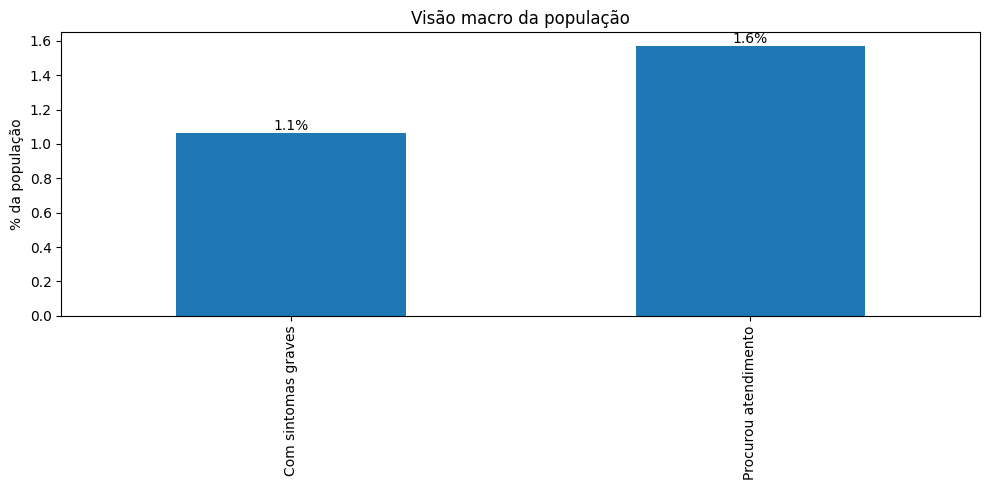

In [23]:

macro = pd.Series({
    'Com sintomas graves': df['tem_grave'].mean()*100,
    'Procurou atendimento': df['procurou_atendimento'].mean()*100
})
plot_bar(macro, 'Visão macro da população')


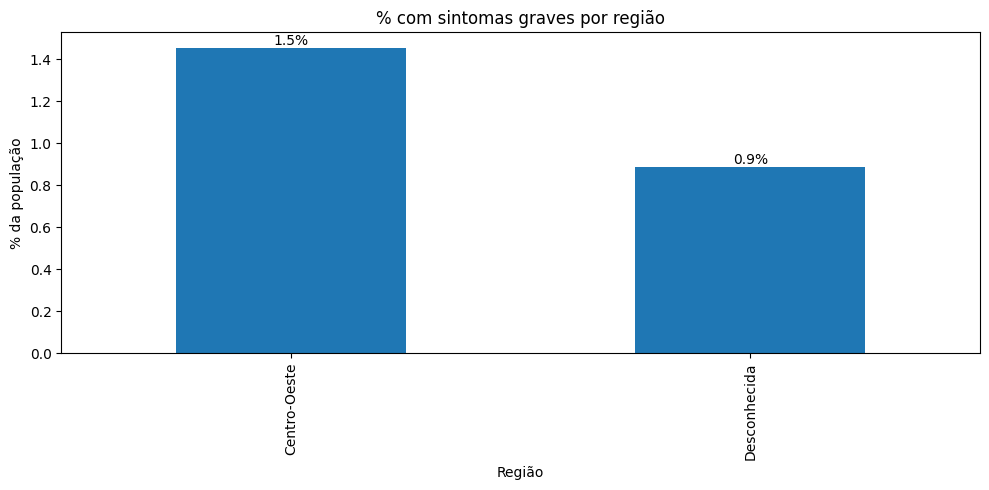

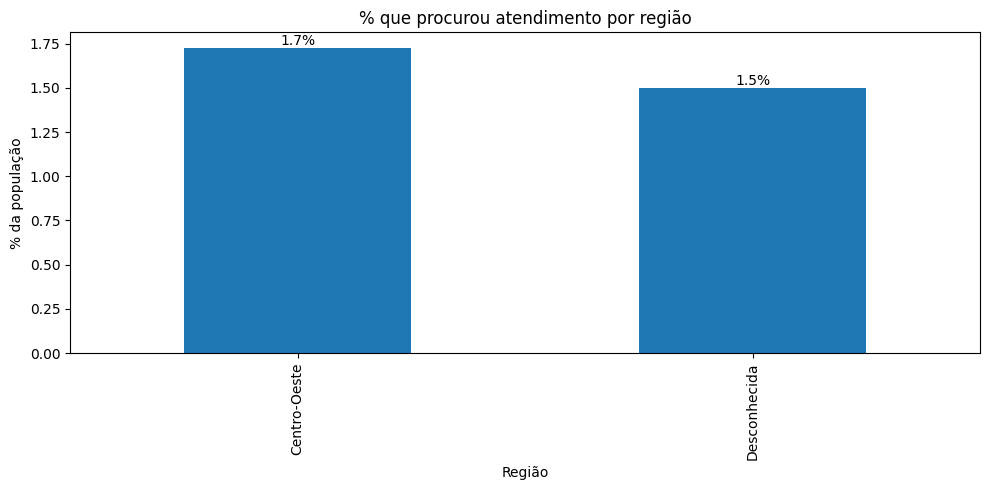

In [24]:

g_reg1 = df.groupby('REGIAO_NOME')['tem_grave'].mean()*100
plot_bar(g_reg1.sort_values(ascending=False), '% com sintomas graves por região', xlabel='Região')

g_reg2 = df.groupby('REGIAO_NOME')['procurou_atendimento'].mean()*100
plot_bar(g_reg2.sort_values(ascending=False), '% que procurou atendimento por região', xlabel='Região')


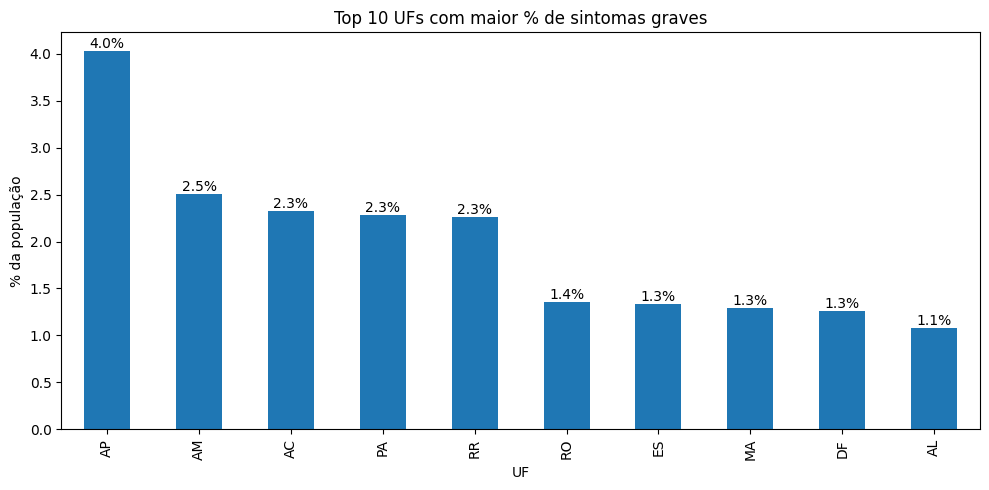

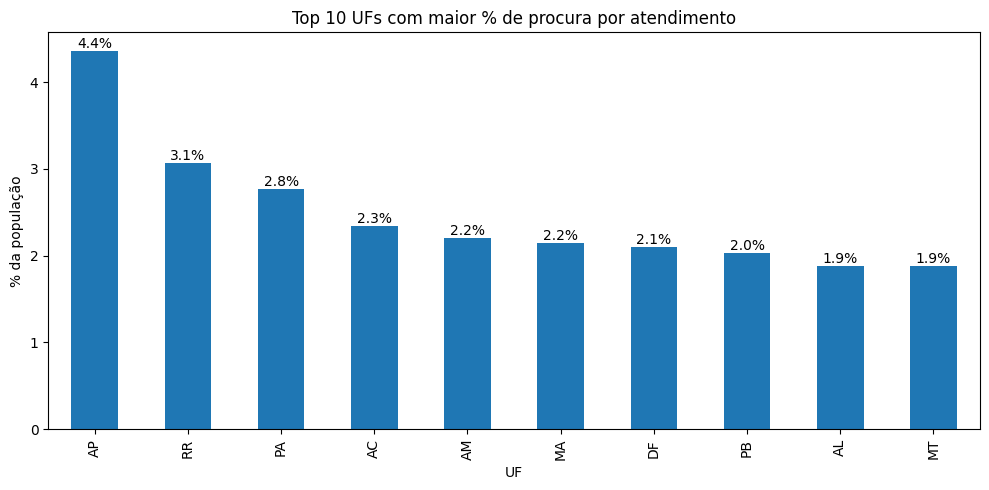

In [25]:

g_uf1 = df.groupby('UF_SIGLA')['tem_grave'].mean()*100
plot_bar(g_uf1.sort_values(ascending=False).head(10), 'Top 10 UFs com maior % de sintomas graves', xlabel='UF')

g_uf2 = df.groupby('UF_SIGLA')['procurou_atendimento'].mean()*100
plot_bar(g_uf2.sort_values(ascending=False).head(10), 'Top 10 UFs com maior % de procura por atendimento', xlabel='UF')


### Estilo de vida

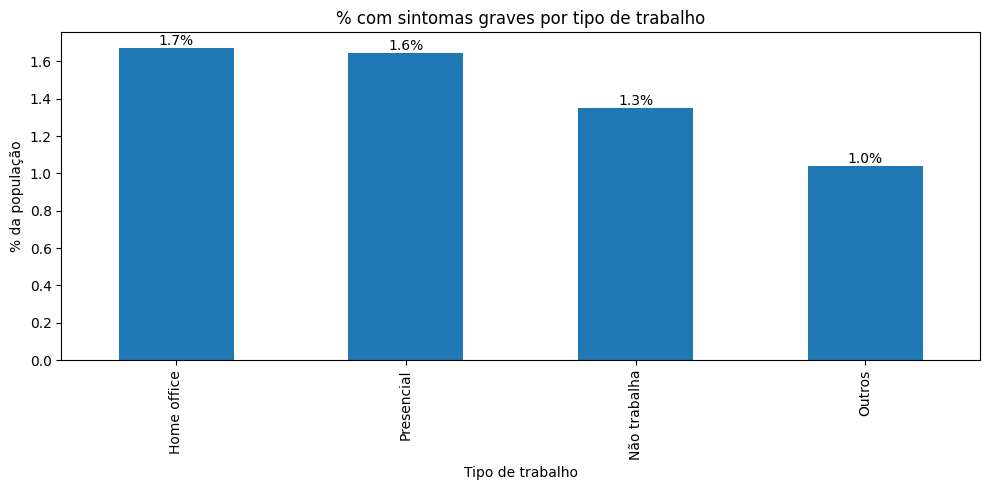

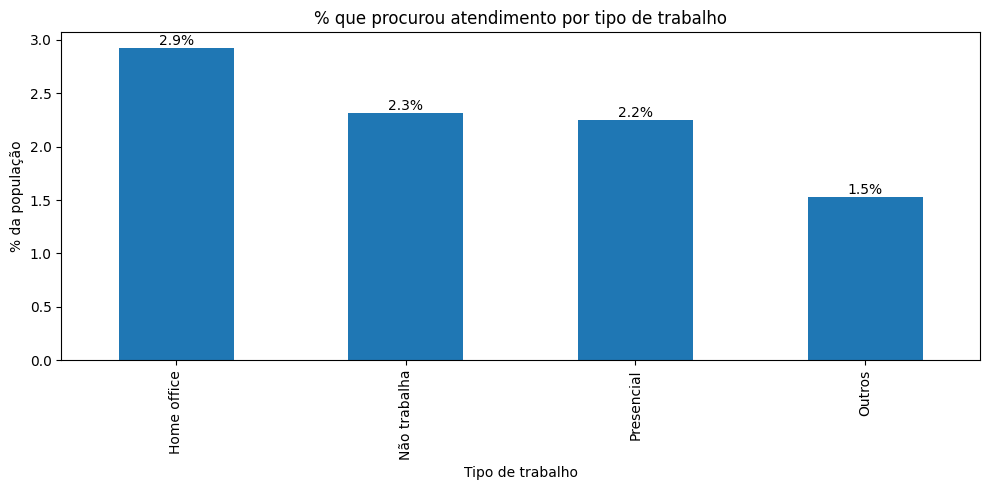

In [26]:

g_trab1 = df.groupby('tipo_trabalho')['tem_grave'].mean()*100
plot_bar(g_trab1.sort_values(ascending=False), '% com sintomas graves por tipo de trabalho', xlabel='Tipo de trabalho')

g_trab2 = df.groupby('tipo_trabalho')['procurou_atendimento'].mean()*100
plot_bar(g_trab2.sort_values(ascending=False), '% que procurou atendimento por tipo de trabalho', xlabel='Tipo de trabalho')


/tmp/ipython-input-2792482593.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g_id1 = df.groupby('faixa_etaria')['tem_grave'].mean()*100


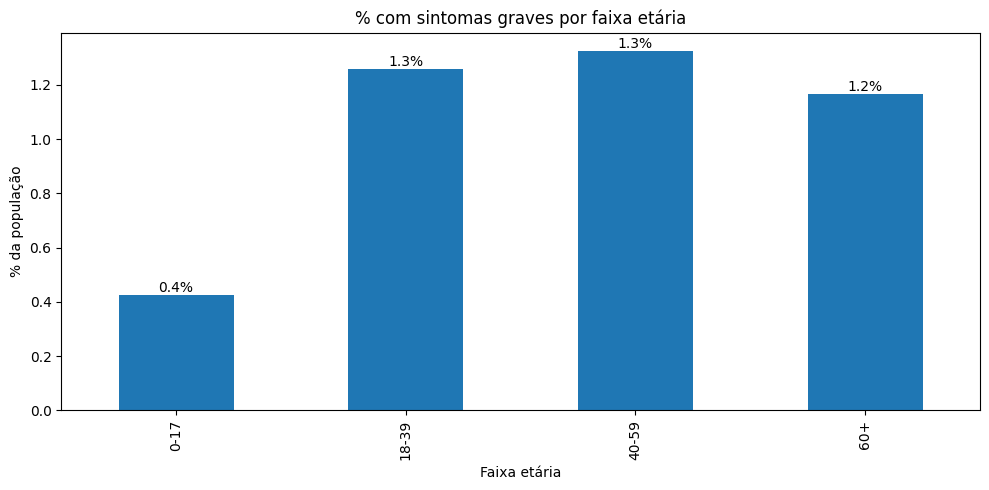

/tmp/ipython-input-2792482593.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g_id2 = df.groupby('faixa_etaria')['procurou_atendimento'].mean()*100


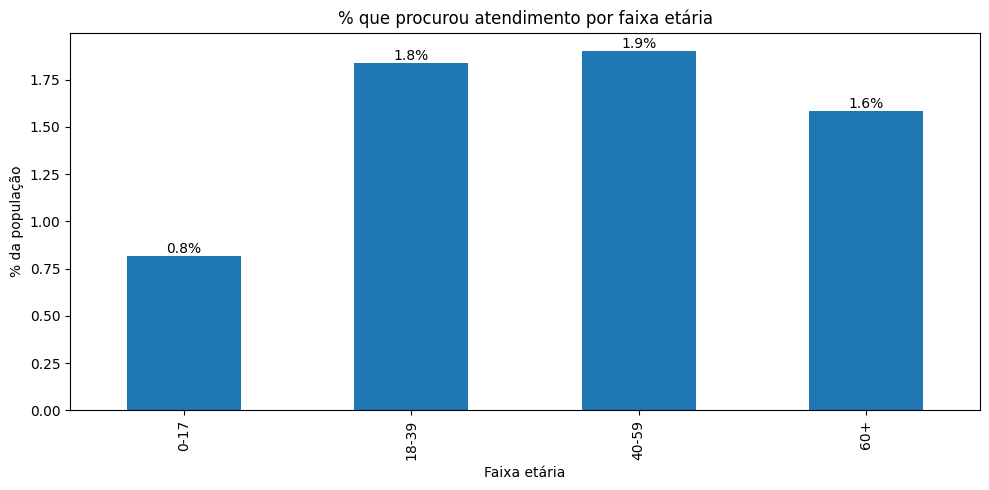

In [27]:

g_id1 = df.groupby('faixa_etaria')['tem_grave'].mean()*100
plot_bar(g_id1, '% com sintomas graves por faixa etária', xlabel='Faixa etária')

g_id2 = df.groupby('faixa_etaria')['procurou_atendimento'].mean()*100
plot_bar(g_id2, '% que procurou atendimento por faixa etária', xlabel='Faixa etária')



## 12. Conclusão Geral

A análise mostra que:

- A gravidade clínica aumenta fortemente com a idade.
- Casos graves são os principais responsáveis pela pressão no sistema de saúde.
- Pessoas que trabalham apresentam, em média, maior exposição e maior risco clínico.
- Existem diferenças regionais e estaduais importantes na gravidade e na procura por atendimento.
- O comportamento de proteção é influenciado pela percepção de risco (viés de seleção).
- O impacto clínico e a organização regional do sistema de saúde são fatores centrais no planejamento hospitalar.
- As visualizações finais utilizam siglas de UF e nomes de região, tornando os resultados legíveis.
- Observa-se heterogeneidade regional e por estilo de trabalho na gravidade e na procura por atendimento.
- A análise macro→micro sustenta recomendações para planejamento de capacidade assistencial.
